In [1]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel 
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_blobs
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
from sklearn import metrics

import matplotlib.pyplot as plt

import string

import pandas as pd
import numpy as np

import time
import threading

from geopy.geocoders import Nominatim

from nltk.tokenize import word_tokenize, regexp_tokenize, sent_tokenize
import nltk
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer

from gensim.test.utils import datapath
from gensim.models.word2vec import Text8Corpus
from gensim.models.phrases import Phrases, Phraser

from geopy.distance import great_circle
from shapely.geometry import MultiPoint

from scipy.spatial.distance import euclidean
from DBCV import DBCV

import randomcolor

In [71]:
wine_df = pd.read_csv('winemag-data-130k-v2.csv')
wine_df.head()

,Unnamed: 0,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
0,0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia
1,1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,NaN,NaN,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos
2,2,US,"Tart and snappy, the flavors of lime flesh and...",NaN,87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm
3,3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,NaN,Alexander Peartree,NaN,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian
4,4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks


In [4]:
wine_df.pop('price')
wine_df.pop('Unnamed: 0')
wine_df.pop('taster_name')
wine_df.pop('taster_twitter_handle')
wine_df.head()

,country,description,designation,points,province,region_1,region_2,title,variety,winery
0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,Sicily & Sardinia,Etna,NaN,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia
1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,Douro,NaN,NaN,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos
2,US,"Tart and snappy, the flavors of lime flesh and...",NaN,87,Oregon,Willamette Valley,Willamette Valley,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm
3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,Michigan,Lake Michigan Shore,NaN,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian
4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,Oregon,Willamette Valley,Willamette Valley,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks


In [2]:
# please DO NOT run this next piece of code as it took me 25 hours to run SO FAR

# calling the Nominatim tool
loc = Nominatim(user_agent="GetLoc")

# this will attempt to return the coordinates of the given location, if no location can be retreived, (0,0) will be returned
def get_coordinates(region_1, province, winery, country):
    try:
        getLoc = loc.geocode(winery + " " + province + " " + country)
        if getLoc == None:
            if type(region_1) == str:
                getLoc = loc.geocode(region_1 + " " + country)
                if getLoc == None:
                    getLoc = loc.geocode(province + " " + country)
                    return(getLoc.latitude, getLoc.longitude)
                else:
                    return(getLoc.latitude, getLoc.longitude)
            else: 
                getLoc = loc.geocode(province + " " + country)
                return(getLoc.latitude, getLoc.longitude)
        else:
            return(getLoc.latitude, getLoc.longitude)
    except:
        return (0,0)

# I have seperated the work into 2 threads as this is the maximum allowed by OpenStreetMap Foundation (OSMF)
# OpenStreetMap is the API that is called upon with the geopy library
# It actually uses the tool Nominatim, developed by OSMF. Nominatim says they allow for a maximum of 1 thread
# however, I found that 2 threads also work. Any more threads results in a ban of several hours.
def calculate_coordinates_for_df_1():
    wine_df_copy_1 = wine_df.iloc[50001:60000,:].copy()
    
    print(len(wine_df_copy_1))
    
    wine_df_copy_1['coordinates'] = wine_df_copy_1.apply(lambda row : get_coordinates(row['region_1'],
                     row['province'], row['winery'], row['country']), axis = 1)

    wine_df_copy_1.to_csv('wines_with_coordinates_3.csv')
    
    print("Finished thread 1")

def calculate_coordinates_for_df_2():
    wine_df_copy_2 = wine_df.iloc[60001:70000,:].copy()
    
    print(len(wine_df_copy_2))
    
    wine_df_copy_2['coordinates'] = wine_df_copy_2.apply(lambda row : get_coordinates(row['region_1'],
                     row['province'], row['winery'], row['country']), axis = 1)

    wine_df_copy_2.to_csv('wines_with_coordinates_4.csv')
    
    print("Finished thread 2")
    
t = time.time()
 
#Created the Threads
t1 = threading.Thread(target=calculate_coordinates_for_df_1)
t2 = threading.Thread(target=calculate_coordinates_for_df_2)
 
print("Starting threads 1 and 2...")
    
#Started the threads
t1.start()
t2.start()
 
#Joined the threads
t1.join()
t2.join()
 
print("Woaahh!! My work is finished..")
print("I took " + str(time.time() - t))    

Exception in thread Thread-6:
Traceback (most recent call last):
  File "c:\users\geronimo\appdata\local\programs\python\python39\lib\threading.py", line 954, in _bootstrap_inner
Exception in thread Thread-7:
Traceback (most recent call last):
  File "c:\users\geronimo\appdata\local\programs\python\python39\lib\threading.py", line 954, in _bootstrap_inner
    self.run()
  File "c:\users\geronimo\appdata\local\programs\python\python39\lib\threading.py", line 892, in run
    self.run()
  File "c:\users\geronimo\appdata\local\programs\python\python39\lib\threading.py", line 892, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-2-b0ee42067f9a>", line 43, in calculate_coordinates_for_df_2
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-2-b0ee42067f9a>", line 31, in calculate_coordinates_for_df_1
NameError: name 'wine_df' is not defined
NameError: name 'wine_df' is not defined


Starting threads 1 and 2...
Woaahh!! My work is finished..
I took 0.0268704891204834


# The following code can be used to append the dataframes retreived from the two threads and afterwards, remove the rows where the coordinates could not be found

#### df = df1.append(df2, ignore_index=True)

#### df = df[~(df['coordinates']=='(0, 0)')]

In [2]:
wine_df = pd.read_csv('wines_with_coordinates.csv')
wine_df.pop('Unnamed: 0')
wine_df.head()

,country,description,designation,points,province,region_1,region_2,title,variety,winery,coordinates,lat,lon
0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,Sicily & Sardinia,Etna,NaN,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia,"(37.7510251, 14.9940321)",37.751025,14.994032
1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,Douro,NaN,NaN,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos,"(41.17004195, -7.304749811735755)",41.170042,-7.304750
2,US,"Tart and snappy, the flavors of lime flesh and...",NaN,87,Oregon,Willamette Valley,Willamette Valley,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm,"(45.3444247, -122.6583007)",45.344425,-122.658301
3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,Michigan,Lake Michigan Shore,NaN,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian,"(27.8169347, -82.6030344)",27.816935,-82.603034
4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,Oregon,Willamette Valley,Willamette Valley,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks,"(43.956565499999996, -123.27938765831485)",43.956566,-123.279388


In [3]:
wine_coordinates = wine_df['coordinates']
coordinates = [tuple(map(float, sub.replace('(','').replace(')','').split(', '))) for sub in wine_coordinates] 
coordinates = list(map(list, zip(*coordinates)))
wine_df['lat'] = coordinates[0]
wine_df['lon'] = coordinates[1]

false_searches = wine_df[(wine_df['lat']<25) & (wine_df['lat']>-23)].index
print("Number of assumed wrong API location searches: {}".format(len(false_searches)))
wine_df = wine_df.drop(false_searches)

wine_df.to_csv('wines_with_coordinates.csv')

Number of assumed wrong API location searches: 0


In [4]:
print("On the nothern hemisphere, the average latitude is: {}".format(wine_df[wine_df['lat']>0]['lat'].abs().mean()))
print("On the southern hemisphere, the average latitude is: {}".format(wine_df[wine_df['lat']<0]['lat'].abs().mean()))
print("For all wines in the dataset, the average latitude is: {}".format(wine_df['lat'].abs().mean()))

On the nothern hemisphere, the average latitude is: 42.13701002804882
On the southern hemisphere, the average latitude is: 35.15420535496259
For all wines in the dataset, the average latitude is: 41.36909977261078


In [23]:
wine_df_copy = wine_df.copy()

wine_df_copy['tokenized_description'] = wine_df['description']

# Split the description in a list of words
wine_df_copy["tokenized_description"] = wine_df_copy["tokenized_description"].str.lower().str.split() 

# Remove punctuation
print("Removing punctuation...")
wine_df_copy['tokenized_description'] = wine_df_copy['tokenized_description'].apply(lambda descriptions: [i.replace(',','').replace('.','').replace('\\','').replace('[','').replace(']','') for i in descriptions])
#wine_df_copy['tokenized_description'] = wine_df_copy['tokenized_description'].apply(normalize_text)

# Remove stopwords
print("Removing stopwords...")
stop_words = set(stopwords.words('english'))
wine_df_copy['tokenized_description'] = wine_df_copy['tokenized_description'].apply(lambda descriptions: [i for i in descriptions if i not in stop_words])

# Use a Stemmer to reduce the words
print("Reducing words...")
stemmer = SnowballStemmer('english')
wine_df_copy['tokenized_description'] = wine_df_copy['tokenized_description'].apply(lambda descriptions: [stemmer.stem(i) for i in descriptions])

# Find common phrases of words that are likely to belong together
print("Finding common phrases...")

phrases = Phrases(wine_df_copy['tokenized_description'])
phrases = Phrases(phrases[wine_df_copy['tokenized_description']])

ngrams = Phraser(phrases)

wine_df_copy['tokenized_description'] = wine_df_copy['tokenized_description'].apply(lambda descriptions: ngrams[descriptions])

# Descriptor mapping
# Wine tasters tend to use creative words to describe the taste of a wine
# These words often are more complicated than need be
# descriptor_mapping.csv contains a mapping of creative words
print("Simplifying creative words... This might take a while...")
descriptor_mapping = pd.read_csv('descriptor_mapping.csv').set_index('raw descriptor')

def return_mapped_descriptor(word):
    if (word in list(descriptor_mapping.index)):
        return descriptor_mapping['level_3'][word]
    else:
        return word

wine_df_copy['tokenized_description'] = wine_df_copy['tokenized_description'].apply(lambda descriptions: [return_mapped_descriptor(i) for i in descriptions])

# Convert list of strings back in one string
print("Converting back to one string...")
wine_df_copy["tokenized_description"] = wine_df_copy["tokenized_description"].apply(lambda descriptions: " ".join([i for i in descriptions]))

wine_df_copy.to_csv('wines_with_coordinates_and_tokenized_descriptions.csv')

wine_df_copy.head()

Removing punctuation...
Removing stopwords...
Reducing words...
Finding common phrases...
Simplifying creative words... This might take a while...
Converting back to one string...


,Unnamed: 0,country,description,designation,points,province,region_1,region_2,title,variety,winery,coordinates,lat,lon,tokenized_description
0,0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,Sicily & Sardinia,Etna,NaN,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia,"(37.7510251, 14.9940321)",37.751025,14.994032,aroma includ tropic_fruit broom brimston dry h...
1,1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,Douro,NaN,NaN,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos,"(41.17004195, -7.304749811735755)",41.170042,-7.304750,ripe fruit wine smooth still structur firm tan...
2,2,US,"Tart and snappy, the flavors of lime flesh and...",NaN,87,Oregon,Willamette Valley,Willamette Valley,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm,"(45.3444247, -122.6583007)",45.344425,-122.658301,tart snappy flavor lime flesh_rind domin green...
3,3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,Michigan,Lake Michigan Shore,NaN,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian,"(27.8169347, -82.6030344)",27.816935,-82.603034,pineapple rind lemon_pith orange_blossom start...
4,4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,Oregon,Willamette Valley,Willamette Valley,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks,"(43.956565499999996, -123.27938765831485)",43.956566,-123.279388,much_like regular_bottl 2012 come_across rathe...


aroma includ tropic_fruit broom brimston dry herb palat over express offer unripen apple citrus dry sage_alongsid brisk_acid


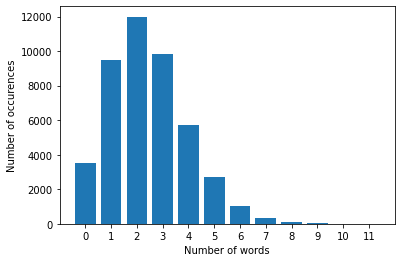

Max number of matching words in a description is: 11


In [6]:
wine_df = pd.read_csv('wines_with_coordinates_and_tokenized_descriptions.csv')

enjoyed_wine = wine_df['tokenized_description'][0]
print(enjoyed_wine)

num_same = []

dont_count_initial = 0

for description in wine_df['tokenized_description']: # Iterate over the descriptions in all wines and count the number 
                                        # of words that also appear in our tokenized descriptions of our enjoyed wines
    if (dont_count_initial < 1):
        dont_count_initial += 1
        continue
        
    counter = 0
    
    split_description = description.split(' ')
    for word in split_description: # If the word is in the tokenized description of our enjoyed wines, increase the counter by 1
        if word in enjoyed_wine:
            counter +=1
        else:
            continue
            
    num_same.append(counter)
        
labels, counts = np.unique(num_same, return_counts=True)
plt.bar(labels, counts, align='center')
plt.gca().set_xticks(labels)
plt.ylabel('Number of occurences')
plt.xlabel('Number of words')
plt.show()


print('Max number of matching words in a description is: ' + str(max(num_same)))  

crisp
fruit
bright
wine
full
live
acid
tangy
citrus
apple
fruit
refreshing
acid
readi_drink
[4709, 23299, 4313, 23416, 6524, 2351, 13438, 1328, 4786, 5022, 23299, 1565, 13438, 1553]


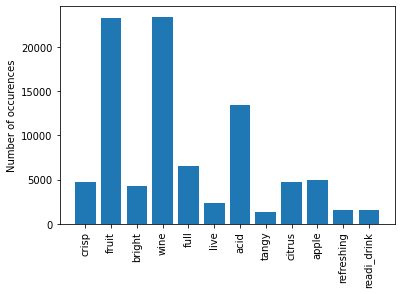

Max number of matching words in a description is: 23416


In [69]:
wine_df = pd.read_csv('wines_with_coordinates_and_tokenized_descriptions.csv')

enjoyed_wine = wine_df['tokenized_description'][33711]

num_same = []

split_wine = enjoyed_wine.split(' ')

for word in split_wine: # Iterate over the descriptions in all wines and count the number 
                                        # of words that also appear in our tokenized descriptions of our enjoyed wines
    print(word)
    dont_count_initial = 0
    
    counter = 0
        
    for description in wine_df['tokenized_description']:
    
        if (dont_count_initial < 1):
            dont_count_initial += 1
            continue
                    
        if word in description:
            counter +=1
        else:
            continue
            
    num_same.append(counter)
        
def addlabels(x,y):
    for i in range(len(x)):
        plt.text(i,y[i],y[i])

        
print(num_same)
labels, counts = np.unique(num_same, return_counts=True)
plt.bar(split_wine, num_same, align='center')
plt.ylabel('Number of occurences')
plt.xticks(rotation=90)
plt.show()

print('Max number of matching words in a description is: ' + str(max(num_same)))  

In [24]:
def tfidf_recommendation_with_wines(df, enjoyed):
    
    """
    Takes in a data frame with wine descriptions, passes the descriptions into a TFIDF function, determines
    the similarity of a given observation/description to the rest of the inputs using cosine similarity, 
    and return a data frame with the top similarity scores for each of our wines.
    """
    
    # Extract the description column from the entered data
    
    all_descriptions = df[['tokenized_description']]
    
    # Initialize a TFIDF Vectorizer model to work with the text data
    
    tf = TfidfVectorizer(analyzer='word',
                     min_df=0,
                     stop_words='english')

    # Use the initiated TFIDF model to transform the data in descriptions
    
    tfidf_matrix = tf.fit_transform(all_descriptions['tokenized_description'])
    
    # Compute the cosine similarities between the items in the newly transformed TFIDF matrix
    cosine_similarities = cosine_similarity(tfidf_matrix,tfidf_matrix)
    
    # Reset the index of the data frame to be able to iterate through the index with our smaller data frame
    enjoyed_wines = df.reset_index()
    enjoyed_wines = enjoyed_wines.iloc[enjoyed]
        
    print("Enjoyed Wines: ")
    print(enjoyed_wines)

    # Initialize a dictionary to store the results
    
    results = {} 

    # Iterate through the observation of the enjoyed wines
    
    for idx, row in enjoyed_wines.iterrows():
        
        similar_indices = cosine_similarities[idx].argsort()[:-7:-1] # Extract the top 5 wines for each observation that was enjoyed
        similar_items = [(cosine_similarities[idx][i], df.reset_index()['index'][i]) for i in similar_indices] # Find the TFIDF score of that item
        results[row['index']] = similar_items[1:] # Append all results after the first (which will be itself) to the dictionary
        
    tfidf_recs = pd.DataFrame()

    # Iterate through the dictionary of results to add the recommended values to a data frame
    
    for k, v in results.items():
    
        for i in v:
        
            tfidf_recs = tfidf_recs.append(df[df.index.isin([i[1]])])
            
    tfidf_scores = []

    # Iterate through the data frame of recommended wines to find their TFIDF scores and add that to the data frame
    
    for i in tfidf_recs.index:
    
        for k, v in results.items():
        
            for ele in v:
            
                if i == ele[1]:
            
                    tfidf_scores.append(ele[0])
                
    tfidf_recs['tfidf_score'] = tfidf_scores
    
    return tfidf_recs

In [8]:
wine_df = pd.read_csv('wines_with_coordinates_and_tokenized_descriptions.csv')

# Apply the new TFIDF predictor to our enjoyed wines

train_wine, test_wine = train_test_split(wine_df, train_size=0.3)

train_wine.reset_index(drop=True, inplace=True)

print(f"Training on {len(train_wine)} samples.")

print("Recommding wine for tokenized description: " + train_wine['tokenized_description'][0])

tfidf_recs = tfidf_recommendation_with_wines(train_wine, [0])

print("Recommendations: ")
print(tfidf_recs.head())

total = train_wine.head(1).append(tfidf_recs)

total.to_csv('tfidf_recommendation_11.csv')

Training on 13440 samples.
Recommding wine for tokenized description: though alcohol_list 143% seem light_bodied flat there littl depth one-dimension green fruit flavor hint plastic burnt finish
Enjoyed Wines: 
   index  Unnamed: 0 country  \
0      0       27524      US   

                                         description designation  points  \
0  Though the alcohol lists at 14.3%, this seems ...     Reserve      84   

  province      region_1         region_2  \
0   Oregon  Rogue Valley  Southern Oregon   

                                               title   variety        winery  \
0  Silvan Ridge 2008 Reserve Viognier (Rogue Valley)  Viognier  Silvan Ridge   

                        coordinates        lat         lon  \
0  (43.957001, -123.26426129327649)  43.957001 -123.264261   

                               tokenized_description  
0  though alcohol_list 143% seem light_bodied fla...  
Recommendations: 
      Unnamed: 0 country                                        de

In [163]:
def tfidf_recommendation_with_words(df, words):
    
    """
    Takes in a data frame with wine descriptions, passes the descriptions into a TFIDF function, determines
    the similarity of a given observation/description to the rest of the inputs using cosine similarity, 
    and return a data frame with the top similarity scores for each of our wines.
    """
    
    # Extract the description column from the entered data
    
    all_descriptions = df[['tokenized_description']]
    
    # Initialize a TFIDF Vectorizer model to work with the text data
    
    tf = TfidfVectorizer(analyzer='word',
                     min_df=0,
                     stop_words='english')

    # Use the initiated TFIDF model to transform the data in descriptions
    
    tfidf_matrix = tf.fit_transform(all_descriptions['tokenized_description'])
    
    tfidf_words = tf.transform([words]) 

    cosine_similarities = cosine_similarity(tfidf_words,tfidf_matrix)[0]

    recommended_indices = cosine_similarities.argsort()[:-6:-1]
    
    recommended_items = [(cosine_similarities[i], df.reset_index()['index'][i]) for i in recommended_indices] # Find the TFIDF score of that item
                    
    tfidf_recs = pd.DataFrame()

    # Iterate through the dictionary of results to add the recommended values to a data frame
    
    for entry in recommended_items:
            
        tfidf_recs = tfidf_recs.append(df[df.index == entry[1]])
                
    tfidf_scores = []

    # Iterate through the data frame of recommended wines to find their TFIDF scores and add that to the data frame
    
    for index in tfidf_recs.index:
        for entry in recommended_items:
            if index == entry[1]:
            
                tfidf_scores.append(entry[0])
                
    tfidf_recs['tfidf_score'] = tfidf_scores
    
    return tfidf_recs

In [170]:
wine_df = pd.read_csv('wines_with_coordinates_and_tokenized_descriptions.csv')

# Apply the new TFIDF predictor to our enjoyed wines

train_wine, test_wine = train_test_split(wine_df, train_size=0.5)

train_wine.reset_index(drop=True, inplace=True)

print(f"Training on {len(train_wine)} samples.")

tfidf_recs = tfidf_recommendation_with_words(train_wine, "crisp fruit bright wine full live acid tangy citrus apple fruit refreshing acid readi_drink")

print("Recommendations: ")
print(tfidf_recs)

Training on 22401 samples.
Recommendations: 
       Unnamed: 0  Unnamed: 0.1   country  \
20715       22591         22591    France   
424           749           749    France   
12282       22479         22479  Portugal   
2773         1459          1459  Portugal   
21769       40313         40313    France   

                                             description  \
20715  Crisp and fruity, this bright wine is full of ...   
424    Crisp while also fruity, it has bright acidity...   
12282  There is a delicious tangy character to this c...   
2773   Crisp, bright and fruity, this is a refreshing...   
21769  A light and bright wine, this offers plenty of...   

                 designation  points      province             region_1  \
20715                  Cruet      88  France Other               Savoie   
424                      NaN      86    Beaujolais  Beaujolais-Villages   
12282                    NaN      85          Tejo                  NaN   
2773   Adega de Borba B

In [9]:
wine_df = pd.read_csv('wines_with_coordinates_and_tokenized_descriptions.csv')

all_descriptions = wine_df[['tokenized_description']]
    
# Initialize a TFIDF Vectorizer model to work with the text data
    
tf = TfidfVectorizer(analyzer='word', min_df=0, stop_words='english')

    # Use the initiated TFIDF model to transform the data in descriptions
    
tfidf_matrix = tf.fit_transform(all_descriptions['tokenized_description'])

print(f"TFIDF matrix has the shape: {tfidf_matrix.shape[0]} by {tfidf_matrix.shape[1]}")

score = np.argsort(np.asarray(tfidf_matrix.sum(axis=0)).ravel())[::-1]
tfidf_feature_names = np.array(tf.get_feature_names())

scores = zip(tf.get_feature_names(), np.asarray(tfidf_matrix.sum(axis=0)).ravel())
sorted_scores = sorted(scores, key=lambda x: x[1], reverse=True)

print("Top 5 TFIDF words:")
for i in range(5):
    print(str(sorted_scores[i][0]) + " - " + str(sorted_scores[i][1]))

print("Bottom 5 TFIDF words:")
for i in range(5):
    print(str(sorted_scores[len(sorted_scores)-1-i][0]) + " - " + str(sorted_scores[len(sorted_scores)-1-i][1]))

TFIDF matrix has the shape: 40856 by 18535
Top 5 TFIDF words:
wine - 1903.6341657687162
fruit - 1678.0128225830572
flavor - 1583.8897825555057
acid - 1208.790123041203
aroma - 1150.2970443328813
Bottom 5 TFIDF words:
rouge - 0.1937172397301834
wagon - 0.2060887052028744
monsoon - 0.2060887052028744
cajol - 0.2060887052028744
wilkinson - 0.20861400991179857


In [39]:
wine_df = pd.read_csv('wines_with_coordinates_and_tokenized_descriptions.csv')

all_descriptions = wine_df[['tokenized_description']]
    
# Initialize a TFIDF Vectorizer model to work with the text data
    
tf = TfidfVectorizer(analyzer='word', min_df=0, stop_words='english')

    # Use the initiated TFIDF model to transform the data in descriptions
    
tfidf_matrix = tf.fit_transform(all_descriptions['tokenized_description'])
tfidf_feature_names = np.array(tf.get_feature_names())

l, w = tfidf_matrix.shape

print(f"TFIDF matrix has the shape: {l} by {w}")



indeces = tfidf_matrix[22591].nonzero()[1]
names = {}
for i in indeces:
    names[i] = tfidf_feature_names[i]

print(names)

print("Example wine:")

print(tfidf_matrix[22591])

print("First recommendation:")

print(tfidf_matrix[7118])

print("Second recommendation:")

print(tfidf_matrix[22479])

print("Third recommendation:")
print(tfidf_matrix[1459])


print(indeces)

#print(tfidf_matrix[0].getcol(1402))

#for i in range(tfidf_matrix[0].shape[1]):
#    print(i)
#    print(tfidf_matrix[0].getcol(i))

#for i in range(5):
#    names[i] = tfidf_feature_names[i]
#    for j in range(5):
#        matrix[i][j] = tfidf_matrix[i][j]
        

TFIDF matrix has the shape: 44802 by 19313
{9923: 'live', 13891: 'readi_drink', 16915: 'tangy', 2713: 'bright', 14006: 'refreshing', 4718: 'crisp', 668: 'acid', 18982: 'wine', 7177: 'fruit', 3868: 'citrus', 1297: 'apple'}
Example wine:
  (0, 9923)	0.3467344570734074
  (0, 13891)	0.34507568972455527
  (0, 16915)	0.3566572620469949
  (0, 2713)	0.26955304080126957
  (0, 14006)	0.3437027150480923
  (0, 4718)	0.25815892137496216
  (0, 668)	0.3559913736381179
  (0, 18982)	0.1326919855369039
  (0, 7177)	0.29766035766806404
  (0, 3868)	0.2635044339714263
  (0, 1297)	0.2714477092664197
First recommendation:
  (0, 9923)	0.3144605860268926
  (0, 17295)	0.2836325147835019
  (0, 12282)	0.3575966497867841
  (0, 1528)	0.3192747489360179
  (0, 13891)	0.31295621591898637
  (0, 16915)	0.3234597812420491
  (0, 18873)	0.29114845441332027
  (0, 4718)	0.23412961719709977
  (0, 668)	0.3228558733955334
  (0, 18982)	0.12034108142927609
  (0, 7177)	0.26995427941981903
  (0, 3868)	0.2389775721361221
Second recom

TFIDF matrix has the shape: 44802 by 19531


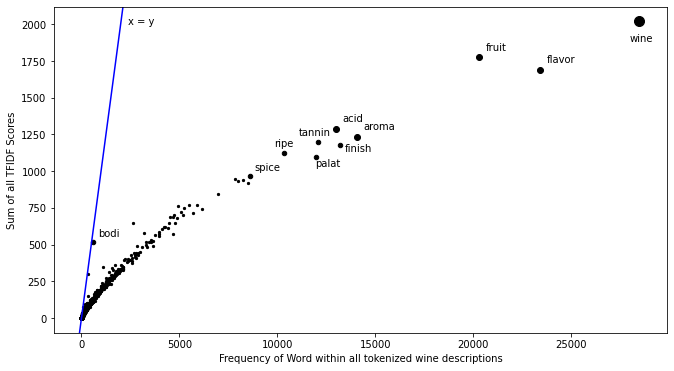

In [157]:
wine_df = pd.read_csv('wines_with_coordinates_and_tokenized_descriptions.csv')

all_descriptions = wine_df[['tokenized_description']]

# Initialize a TFIDF Vectorizer model to work with the text data
    
tf = TfidfVectorizer(use_idf=True)

# Use the initiated TFIDF model to transform the data in the tokenized descriptions
    
tfidf_matrix = tf.fit_transform(all_descriptions['tokenized_description'])

print(f"TFIDF matrix has the shape: {tfidf_matrix.shape[0]} by {tfidf_matrix.shape[1]}") 

score = np.argsort(np.asarray(tfidf_matrix.sum(axis=0)).ravel())[::-1]
tfidf_feature_names = np.array(tf.get_feature_names())

scores = zip(tf.get_feature_names(), np.asarray(tfidf_matrix.sum(axis=0)).ravel())

#tfIdfVectorizer=TfidfVectorizer(use_idf=True)
#tfIdf = tfIdfVectorizer.fit_transform(dataset)
#df = pd.DataFrame(tfidf_matrix[0].T.todense(), index=tf.get_feature_names(), columns=["TF-IDF"])
#df = df.sort_values('TF-IDF', ascending=False)
#print (df.head(25))
    
#scores = zip(tf.get_feature_names(), tfidf_matrix.toarray()[0])

sorted_scores = sorted(scores, key=lambda x: x[1], reverse=True)

#print(len(sorted_scores))

#all_descriptions_copy = all_descriptions.copy()
#all_descriptions_copy['tokenized_description'] = all_descriptions['tokenized_description'].str.split()
#print(list(set(all_descriptions_copy['tokenized_description'][0])))
#all_descriptions_copy['tokenized_description'] = all_descriptions_copy.apply(lambda description: list(set(description)))
#all_descriptions_copy['tokenized_description'] = all_descriptions_copy['tokenized_description'].apply(lambda descriptions: " ".join([i for i in descriptions]))
word_counts = all_descriptions['tokenized_description'].str.split(expand=True).stack().value_counts()

fig, ax = plt.subplots(figsize=[11, 6])

ax.set_xlabel('Frequency of Word within all tokenized wine descriptions')
ax.set_ylabel('Sum of all TFIDF Scores')

ax.annotate(str(sorted_scores[0][0]), (word_counts[str(sorted_scores[0][0])], sorted_scores[0][1]), xytext=(-10,-20), textcoords='offset points')
plt.scatter(word_counts[str(sorted_scores[0][0])], sorted_scores[0][1], marker='o', color='black', s=100)

for i in range(1,5):
    ax.annotate(str(sorted_scores[i][0]), (word_counts[str(sorted_scores[i][0])], sorted_scores[i][1]), xytext=(7,7), textcoords='offset points')
    plt.scatter(word_counts[str(sorted_scores[i][0])], sorted_scores[i][1], marker='o', color='black')

ax.annotate(str(sorted_scores[5][0]), (word_counts[str(sorted_scores[5][0])], sorted_scores[5][1]), xytext=(-20,7), textcoords='offset points')
plt.scatter(word_counts[str(sorted_scores[5][0])], sorted_scores[5][1], marker='o', color='black', s=20)    
    
ax.annotate(str(sorted_scores[6][0]), (word_counts[str(sorted_scores[6][0])], sorted_scores[6][1]), xytext=(5,-7), textcoords='offset points')
plt.scatter(word_counts[str(sorted_scores[6][0])], sorted_scores[6][1], marker='o', color='black', s=20)

ax.annotate(str(sorted_scores[7][0]), (word_counts[str(sorted_scores[7][0])], sorted_scores[7][1]), xytext=(-10,7), textcoords='offset points')
plt.scatter(word_counts[str(sorted_scores[7][0])], sorted_scores[7][1], marker='o', color='black', s=20)

ax.annotate(str(sorted_scores[8][0]), (word_counts[str(sorted_scores[8][0])], sorted_scores[8][1]), xytext=(0,-10), textcoords='offset points')
plt.scatter(word_counts[str(sorted_scores[8][0])], sorted_scores[8][1], marker='o', color='black', s=20)

ax.annotate(str(sorted_scores[9][0]), (word_counts[str(sorted_scores[9][0])], sorted_scores[9][1]), xytext=(5,5), textcoords='offset points')
plt.scatter(word_counts[str(sorted_scores[9][0])], sorted_scores[9][1], marker='o', color='black', s=20)

ax.annotate(str(sorted_scores[43][0]), (word_counts[str(sorted_scores[43][0])], sorted_scores[43][1]), xytext=(5,5), textcoords='offset points')
plt.scatter(word_counts[str(sorted_scores[43][0])], sorted_scores[43][1], marker='o', color='black', s=20)

not_top_scores = sorted_scores[9:]

x = [0 for _ in range(len(not_top_scores))]
y = [0 for _ in range(len(not_top_scores))]

max_length = len(sorted_scores)

for i in range(len(not_top_scores)):
    try:
        if sorted_scores[max_length - 1 - i][1] / word_counts[str(sorted_scores[max_length - 1 - i][0])] <= 1:
            x[i] = word_counts[str(sorted_scores[max_length - 1 - i][0])]
            y[i] = sorted_scores[max_length - 1 - i][1]
    except:
        continue
        
plt.scatter(x, y, marker='o',s=5, color='black')

#xdata = list(range(2000))
#ydata = list(range(2000))

xpoints = ypoints = plt.xlim()
ax.annotate("x = y", (2400, 2000))
plt.plot(xpoints, ypoints, linestyle='-', color='b', lw=1.5, scalex=False, scaley=False)

#plt.plot(xdata, ydata, 'b')
    
plt.show()


TFIDF matrix has the shape: 3934 by 19531


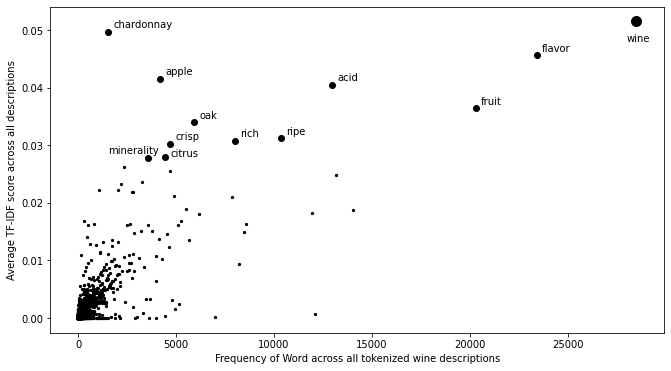

In [40]:
wine_df = pd.read_csv('wines_with_coordinates_and_tokenized_descriptions.csv')

all_descriptions = wine_df[['tokenized_description']]

# Initialize a TFIDF Vectorizer model to work with the text data
    
tf = TfidfVectorizer(use_idf=True)

# Use the initiated TFIDF model to transform the data in the tokenized descriptions
    
tf.fit(all_descriptions['tokenized_description'])

word_counts = all_descriptions['tokenized_description'].str.split(expand=True).stack().value_counts()

wine_df = wine_df[wine_df['variety']=="Chardonnay"]

all_descriptions = wine_df[['tokenized_description']]

tfidf_matrix = tf.transform(all_descriptions['tokenized_description'])

print(f"TFIDF matrix has the shape: {tfidf_matrix.shape[0]} by {tfidf_matrix.shape[1]}") 

score = np.argsort(np.asarray(tfidf_matrix.mean(axis=0)).ravel())[::-1]
tfidf_feature_names = np.array(tf.get_feature_names())

scores = zip(tf.get_feature_names(), np.asarray(tfidf_matrix.mean(axis=0)).ravel())

#tfIdfVectorizer=TfidfVectorizer(use_idf=True)
#tfIdf = tfIdfVectorizer.fit_transform(dataset)
#df = pd.DataFrame(tfidf_matrix[0].T.todense(), index=tf.get_feature_names(), columns=["TF-IDF"])
#df = df.sort_values('TF-IDF', ascending=False)
#print (df.head(25))
    
#scores = zip(tf.get_feature_names(), tfidf_matrix.toarray()[0])

sorted_scores = sorted(scores, key=lambda x: x[1], reverse=True)

#print(len(sorted_scores))

#all_descriptions_copy = all_descriptions.copy()
#all_descriptions_copy['tokenized_description'] = all_descriptions['tokenized_description'].str.split()
#print(list(set(all_descriptions_copy['tokenized_description'][0])))
#all_descriptions_copy['tokenized_description'] = all_descriptions_copy.apply(lambda description: list(set(description)))
#all_descriptions_copy['tokenized_description'] = all_descriptions_copy['tokenized_description'].apply(lambda descriptions: " ".join([i for i in descriptions]))

fig, ax = plt.subplots(figsize=[11, 6])

ax.set_xlabel('Frequency of Word across all tokenized wine descriptions')
ax.set_ylabel('Average TF-IDF score across all descriptions')

ax.annotate(str(sorted_scores[0][0]), (word_counts[str(sorted_scores[0][0])], sorted_scores[0][1]), xytext=(-10,-20), textcoords='offset points')
plt.scatter(word_counts[str(sorted_scores[0][0])], sorted_scores[0][1], marker='o', color='black', s=100)

for i in range(1,10):
    ax.annotate(str(sorted_scores[i][0]), (word_counts[str(sorted_scores[i][0])], sorted_scores[i][1]), xytext=(5,4), textcoords='offset points')
    plt.scatter(word_counts[str(sorted_scores[i][0])], sorted_scores[i][1], marker='o', color='black')

    
ax.annotate(str(sorted_scores[10][0]), (word_counts[str(sorted_scores[10][0])], sorted_scores[10][1]), xytext=(5,0), textcoords='offset points')
plt.scatter(word_counts[str(sorted_scores[10][0])], sorted_scores[10][1], marker='o', color='black')

ax.annotate(str(sorted_scores[11][0]), (word_counts[str(sorted_scores[11][0])], sorted_scores[11][1]), xytext=(-40,5), textcoords='offset points')
plt.scatter(word_counts[str(sorted_scores[11][0])], sorted_scores[11][1], marker='o', color='black')

not_top_scores = sorted_scores[10:]

x = [0 for _ in range(len(not_top_scores))]
y = [0 for _ in range(len(not_top_scores))]

max_length = len(sorted_scores)

for i in range(len(not_top_scores)):
    try:
        if sorted_scores[max_length - 1 - i][1] / word_counts[str(sorted_scores[max_length - 1 - i][0])] <= 1:
            x[i] = word_counts[str(sorted_scores[max_length - 1 - i][0])]
            y[i] = sorted_scores[max_length - 1 - i][1]
    except:
        continue
        
plt.scatter(x, y, marker='o',s=5, color='black')
    
plt.show()


TFIDF matrix has the shape: 4429 by 7157


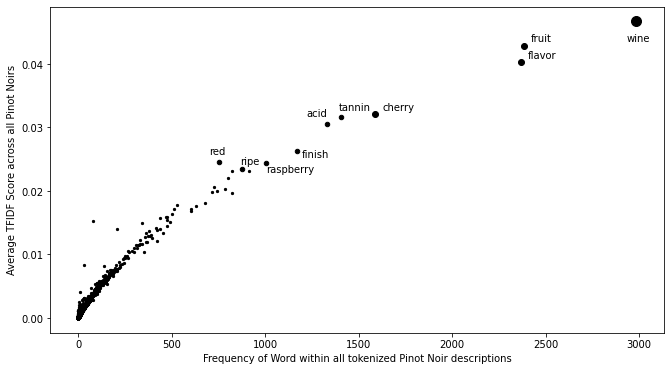

In [120]:
wine_df = pd.read_csv('wines_with_coordinates_and_tokenized_descriptions.csv')

wine_df = wine_df[wine_df['variety']=="Pinot Noir"]

all_descriptions = wine_df[['tokenized_description']]

# Initialize a TFIDF Vectorizer model to work with the text data
    
tf = TfidfVectorizer(use_idf=True)

# Use the initiated TFIDF model to transform the data in the tokenized descriptions
    
tfidf_matrix = tf.fit_transform(all_descriptions['tokenized_description'])

print(f"TFIDF matrix has the shape: {tfidf_matrix.shape[0]} by {tfidf_matrix.shape[1]}") 

score = np.argsort(np.asarray(tfidf_matrix.mean(axis=0)).ravel())[::-1]
tfidf_feature_names = np.array(tf.get_feature_names())

scores = zip(tf.get_feature_names(), np.asarray(tfidf_matrix.mean(axis=0)).ravel())

#tfIdfVectorizer=TfidfVectorizer(use_idf=True)
#tfIdf = tfIdfVectorizer.fit_transform(dataset)
#df = pd.DataFrame(tfidf_matrix[0].T.todense(), index=tf.get_feature_names(), columns=["TF-IDF"])
#df = df.sort_values('TF-IDF', ascending=False)
#print (df.head(25))
    
#scores = zip(tf.get_feature_names(), tfidf_matrix.toarray()[0])

sorted_scores = sorted(scores, key=lambda x: x[1], reverse=True)

#print(len(sorted_scores))

#all_descriptions_copy = all_descriptions.copy()
#all_descriptions_copy['tokenized_description'] = all_descriptions['tokenized_description'].str.split()
#print(list(set(all_descriptions_copy['tokenized_description'][0])))
#all_descriptions_copy['tokenized_description'] = all_descriptions_copy.apply(lambda description: list(set(description)))
#all_descriptions_copy['tokenized_description'] = all_descriptions_copy['tokenized_description'].apply(lambda descriptions: " ".join([i for i in descriptions]))
word_counts = all_descriptions['tokenized_description'].str.split(expand=True).stack().value_counts()

fig, ax = plt.subplots(figsize=[11, 6])

ax.set_xlabel('Frequency of Word within all tokenized Pinot Noir descriptions')
ax.set_ylabel('Average TFIDF Score across all Pinot Noirs')

ax.annotate(str(sorted_scores[0][0]), (word_counts[str(sorted_scores[0][0])], sorted_scores[0][1]), xytext=(-10,-20), textcoords='offset points')
plt.scatter(word_counts[str(sorted_scores[0][0])], sorted_scores[0][1], marker='o', color='black', s=100)

for i in range(1,4):
    ax.annotate(str(sorted_scores[i][0]), (word_counts[str(sorted_scores[i][0])], sorted_scores[i][1]), xytext=(7,4), textcoords='offset points')
    plt.scatter(word_counts[str(sorted_scores[i][0])], sorted_scores[i][1], marker='o', color='black')

ax.annotate(str(sorted_scores[4][0]), (word_counts[str(sorted_scores[4][0])], sorted_scores[4][1]), xytext=(-2,7), textcoords='offset points')
plt.scatter(word_counts[str(sorted_scores[4][0])], sorted_scores[4][1], marker='o', color='black', s=20)       
    
ax.annotate(str(sorted_scores[5][0]), (word_counts[str(sorted_scores[5][0])], sorted_scores[5][1]), xytext=(-20,7), textcoords='offset points')
plt.scatter(word_counts[str(sorted_scores[5][0])], sorted_scores[5][1], marker='o', color='black', s=20)    
    
ax.annotate(str(sorted_scores[6][0]), (word_counts[str(sorted_scores[6][0])], sorted_scores[6][1]), xytext=(5,-7), textcoords='offset points')
plt.scatter(word_counts[str(sorted_scores[6][0])], sorted_scores[6][1], marker='o', color='black', s=20)

ax.annotate(str(sorted_scores[7][0]), (word_counts[str(sorted_scores[7][0])], sorted_scores[7][1]), xytext=(-10,7), textcoords='offset points')
plt.scatter(word_counts[str(sorted_scores[7][0])], sorted_scores[7][1], marker='o', color='black', s=20)

ax.annotate(str(sorted_scores[8][0]), (word_counts[str(sorted_scores[8][0])], sorted_scores[8][1]), xytext=(0,-10), textcoords='offset points')
plt.scatter(word_counts[str(sorted_scores[8][0])], sorted_scores[8][1], marker='o', color='black', s=20)

ax.annotate(str(sorted_scores[9][0]), (word_counts[str(sorted_scores[9][0])], sorted_scores[9][1]), xytext=(-2,5), textcoords='offset points')
plt.scatter(word_counts[str(sorted_scores[9][0])], sorted_scores[9][1], marker='o', color='black', s=20)

not_top_scores = sorted_scores[9:]

x = [0 for _ in range(len(not_top_scores))]
y = [0 for _ in range(len(not_top_scores))]

max_length = len(sorted_scores)

for i in range(len(not_top_scores)):
    try:
        if sorted_scores[max_length - 1 - i][1] / word_counts[str(sorted_scores[max_length - 1 - i][0])] <= 1:
            x[i] = word_counts[str(sorted_scores[max_length - 1 - i][0])]
            y[i] = sorted_scores[max_length - 1 - i][1]
    except:
        continue
        
plt.scatter(x, y, marker='o',s=5, color='black')

#xdata = list(range(2000))
#ydata = list(range(2000))

#plt.plot(xdata, ydata, 'b')
    
plt.show()


Number of clusters: 35
Number of noise points: 405


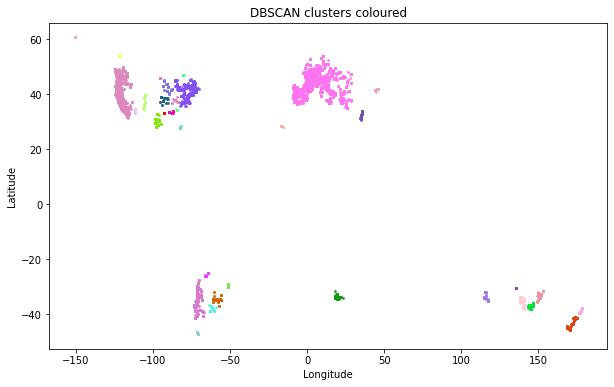

In [20]:
wine_df = pd.read_csv('wines_with_coordinates_and_tokenized_descriptions.csv')

coordinates = wine_df[['lat', 'lon']]

kms_per_radian = 6371.0088
epsilon = 200 / kms_per_radian
db = DBSCAN(eps=epsilon, min_samples=20, algorithm='ball_tree', metric='haversine').fit(np.radians(coordinates))
cluster_labels = db.labels_
num_clusters = len(set(cluster_labels))
clusters = pd.Series([coordinates[cluster_labels == n] for n in range(num_clusters - 1)])
core_samples_mask = np.zeros_like(cluster_labels, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True

print('Number of clusters: {}'.format(num_clusters))
range_max = len(coordinates)

num_noise = np.sum(np.array(cluster_labels) == -1, axis=0)
print('Number of noise points: {}'.format(num_noise))

#print('DBCV score: {:0.03f}'.format(DBCV(coordinates.values, cluster_labels, dist_function=euclidean)))

#print('Silhouette coefficient: {:0.03f}'.format(metrics.silhouette_score(coordinates, cluster_labels)))

#print('Davies Bouldin Score: {:0.03f}'.format(metrics.davies_bouldin_score(coordinates, cluster_labels)))

colors = list("bgrcmy")
fig, ax = plt.subplots(figsize=[10, 6])
for cluster in clusters:
    ax.scatter(cluster['lon'],cluster['lat'], c=randomcolor.RandomColor().generate(), alpha=0.9, s=3)
ax.set_title('DBSCAN clusters coloured')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
plt.show()

Number of clusters: 27
Number of noise points: 1210


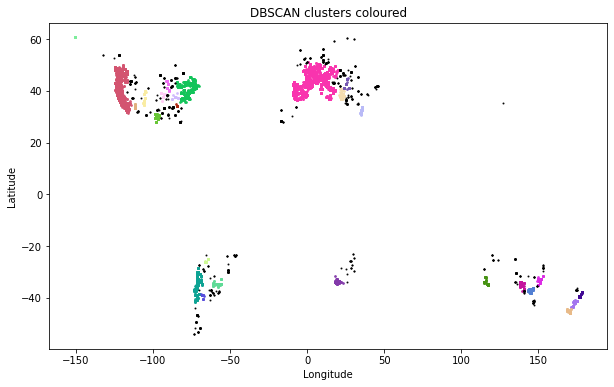

In [10]:
wine_df = pd.read_csv('wines_with_coordinates_and_tokenized_descriptions.csv')

coordinates = wine_df.copy()[['lat', 'lon']]

kms_per_radian = 6371.0088
epsilon = 210 / kms_per_radian
db = DBSCAN(eps=epsilon, min_samples=50, algorithm='ball_tree', metric='euclidean').fit(np.radians(coordinates))
cluster_labels = db.labels_
num_clusters = len(set(cluster_labels))
clusters = pd.Series([coordinates[cluster_labels == n] for n in range(num_clusters - 1)])

coordinates['colour'] = cluster_labels

noise = coordinates[coordinates.colour==-1]

print('Number of clusters: {}'.format(num_clusters))

print('Number of noise points: {}'.format(len(noise)))

#print('DBCV score: {:0.03f}'.format(DBCV(coordinates.values, cluster_labels, dist_function=euclidean)))

#print('Silhouette coefficient: {:0.03f}'.format(metrics.silhouette_score(coordinates, cluster_labels)))

#print('Davies Bouldin Score: {:0.03f}'.format(metrics.davies_bouldin_score(coordinates, cluster_labels)))

#ax.scatter(coordinates[:,0], coordinates[:,1], c=colors, marker="o", picker=True)

fig, ax = plt.subplots(figsize=[10, 6])
for cluster in clusters:
    ax.scatter(cluster['lon'],cluster['lat'], c=randomcolor.RandomColor().generate(), alpha=0.9, s=3)
ax.scatter(noise['lon'], noise['lat'], c='black', marker="o", picker=True, alpha=0.9, s=1)
ax.set_title('DBSCAN clusters coloured')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
plt.show()

In [11]:
# To check which epsilon would result in the best measurement results:

wine_df = pd.read_csv('wines_with_coordinates_and_tokenized_descriptions.csv')

train_wine, test_wine = train_test_split(wine_df, train_size=0.5)

train_wine.reset_index(drop=True, inplace=True)

coordinates = train_wine[['lat', 'lon']]

silhouette_scores = {}
    
kms_per_radian = 6371.0088
epsilon = 1 / kms_per_radian
db = DBSCAN(eps=epsilon, min_samples=50, algorithm='ball_tree', metric='euclidean').fit(np.radians(coordinates))
cluster_labels = db.labels_
    
silhouette_scores[1] = metrics.silhouette_score(coordinates, cluster_labels)

for i in range(10,1001,10):
    print("Currently calculating epsilon "+ str(i))
    
    kms_per_radian = 6371.0088
    epsilon = i / kms_per_radian
    db = DBSCAN(eps=epsilon, min_samples=50, algorithm='ball_tree', metric='euclidean').fit(np.radians(coordinates))
    cluster_labels = db.labels_

    #DBCV_scores[i] = DBCV(coordinates, cluster_labels, dist_function=euclidean)
    
    silhouette_scores[i] = metrics.silhouette_score(coordinates, cluster_labels)
    
plt.figure(figsize=(10,6))
plt.plot(list(silhouette_scores.keys()), list(silhouette_scores.values()))
plt.xlabel("Epsilon in km")
plt.ylabel("Silhouette score")
plt.show()


Currently calculating epsilon 10
Currently calculating epsilon 20
Currently calculating epsilon 30
Currently calculating epsilon 40
Currently calculating epsilon 50


KeyboardInterrupt: 

In [9]:
for key in silhouette_scores.keys():
    print(str(key), str(silhouette_scores[key]))

1 -0.44164780725687364
10 -0.16083299315211452
20 0.034352376983633574
30 0.14255737356173828
40 0.2538977775533153
50 0.28105548223498267
60 0.34870713798573655
70 0.3282857333555301
80 0.2373651935630464
90 0.3988181374545534
100 0.3096800086895346
110 0.20761177312979628
120 0.20752030006103409
130 0.2188987250149907
140 0.19790862285333605
150 0.1345843448117639
160 0.1852691756786202
170 0.2762869142008164
180 0.22848222115593061
190 0.327224349665514
200 0.3077600155288927
210 0.7383612910008487
220 0.7423993645795571
230 0.7444102359944736
240 0.7464584182035584
250 0.7490676652622653
260 0.7508078665339437
270 0.7515201378432395
280 0.769575929951042
290 0.7723672130173392
300 0.7756522986314498
310 0.7773176013904608
320 0.7778057210692002
330 0.7788871165391098
340 0.7806570621783769
350 0.5885227235824099
360 0.5544117001882226
370 0.5548432396063662
380 0.5595898257657376
390 0.5704204520260069
400 0.5811765237487674
410 0.5819288480298374
420 0.5840933323313753
430 0.58793

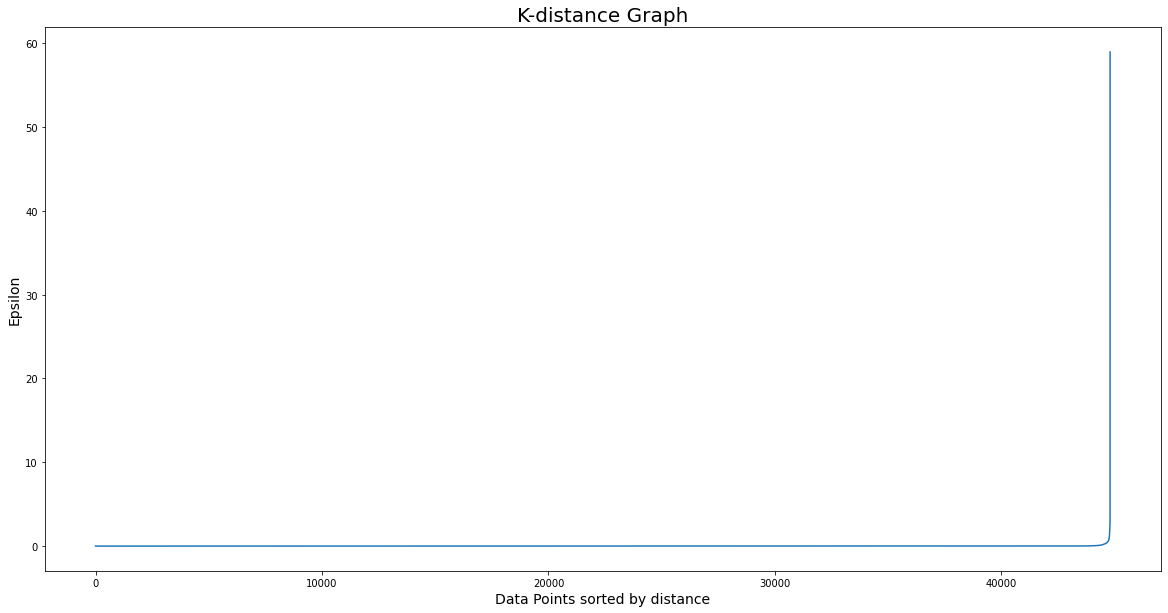

In [6]:
from sklearn.neighbors import NearestNeighbors

wine_df = pd.read_csv('wines_with_coordinates_and_tokenized_descriptions.csv')

coordinates = wine_df[['lat', 'lon']]

neigh = NearestNeighbors(n_neighbors=1000)

nbrs = neigh.fit(coordinates)

distances, indices = nbrs.kneighbors(coordinates)

distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.figure(figsize=(20,10))
plt.plot(distances)
plt.title('K-distance Graph',fontsize=20)
plt.xlabel('Data Points sorted by distance',fontsize=14)
plt.ylabel('Epsilon',fontsize=14)
plt.show()

In [21]:
def get_centermost_point(cluster):
    cluster_as_tuple = list(zip(cluster['lat'], cluster['lon']))
    centroid = (MultiPoint(cluster_as_tuple).centroid.x, MultiPoint(cluster_as_tuple).centroid.y)
    centermost_point = min(cluster_as_tuple, key=lambda point: great_circle(point, centroid).m)
    return tuple(centermost_point)

centermost_points = clusters.map(get_centermost_point)

lats, lons = zip(*centermost_points)
rep_points = pd.DataFrame({'lon':lons, 'lat':lats})

rep_points = rep_points.apply(lambda row: wine_df[(wine_df['lat']==row['lat']) & (wine_df['lon']==row['lon'])].iloc[0], axis=1)

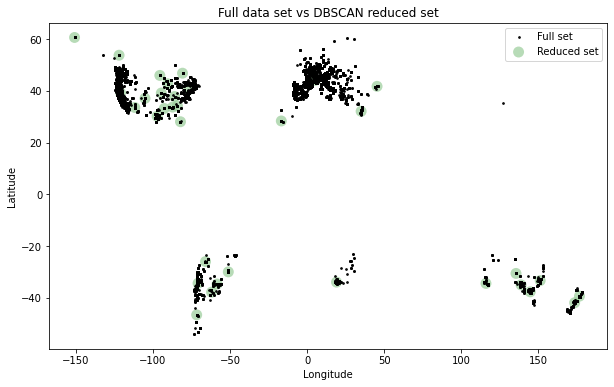

In [22]:


# plot the final reduced set of coordinate points vs the original full set
fig, ax = plt.subplots(figsize=[10, 6])
rs_scatter = ax.scatter(rep_points['lon'], rep_points['lat'], c='#99cc99', edgecolor='None', alpha=0.7, s=120)
df_scatter = ax.scatter(wine_df['lon'], wine_df['lat'], c='k', alpha=0.9, s=3)
ax.set_title('Full data set vs DBSCAN reduced set')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.legend([df_scatter, rs_scatter], ['Full set', 'Reduced set'], loc='upper right')
plt.show()